In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# What is backpropagation?

Micrograd is an autograd engine which implements backpropagation. 

* Backpropagation is an algorithm which allows one to efficiently evaluate the gradient of a **loss function** with respect to the weights of a neural network
* This lets us iteratively tune the weights to minimise the loss function, and hence improve the performance of the NN

# What is a derivative?
What information does it contain?

## 1. Define (and call) a single-value scalar function `f(x)`

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

# call function
f(3.0)

20.0

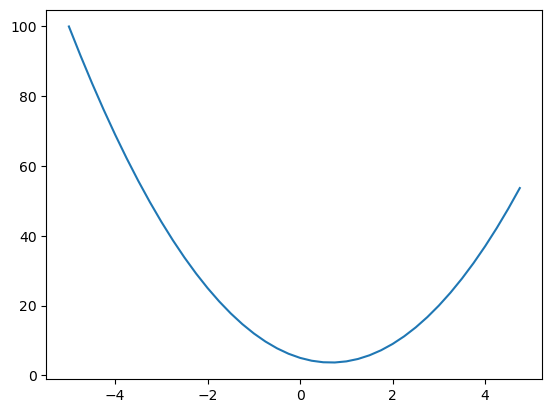

In [3]:
# plot function to understand its shape
xs = np.arange(-5, 5, 0.25) # array of x values
ys = f(xs)                  # corresp. array of y values
plt.plot(xs, ys)

## 2. Take the derivative (i.e. `df(x)/dx` at any input point `x`)

* Recall, in Calculus class, you'd use the various **analytical** rules (e.g. product rule etc) on the function $3x^2 -4x + 5$ defined above to find the **analytical** expression for the derivative of $f(x)$.
* In NNs, no one does this. The expression would have tens of thousands of terms.

### Instead, by definition a derivative is:
$$L = \lim_{h \to 0} \frac{f(x+h)-f(x)}{h}$$

Which tells us the sensitivity (aka slope of the response) of the function, to when you nudge $x$ by an infinitesimal amount $h$

In [4]:
h = 0.00000001
x = 3.0
(f(x + h) - f(x))/h # recall: rise/run; that's why we "normalise" by dividing by h

14.00000009255109

Note, we can confirm analytically for this function; $\frac{\mathrm{d}}{\mathrm{d}x}(3x^2-4x+5) = 6x-4 \implies 6(3)-4=14$

## 3. Derivative of `d` wrt multiple inputs `a`, `b`, and `c`

In [5]:
# let's get more complex
a = 2.0
b = -3.0
c = 10.0   
d = a*b + c
print(d)

4.0


In [6]:
h = 0.0001

# inputs (point coordinates (a,b,c) at which we're evaluating derivative of d)
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

# let's nudge each of our variables one at a time
a += h # first nudge a
d2_a = a*b + c

b += h # next nudge b
a -= h # (un-nudge a)
d2_b = a*b + c

c += h # finally nudge c
b -= h # (un-nudge b)
d2_c = a*b + c

print('d1', d1)
print('\nd2_a', d2_a)
print('slope (d wrt a):', (d2_a - d1)/h)
print('\nd2_b', d2_b)
print('slope (d wrt b):', (d2_b - d1)/h)
print('\nd2_c', d2_c)
print('slope (d wrt c):', (d2_c - d1)/h)
print('\nEnsure the above makes sense.')
print('Think about the analytical solutions: of d(d)/da = -b, d(d)/db = a, and d(d)/dc = 1')

d1 4.0

d2_a 3.999699999999999
slope (d wrt a): -3.000000000010772

d2_b 4.0002
slope (d wrt b): 2.0000000000042206

d2_c 4.0001
slope (d wrt c): 0.9999999999976694

Ensure the above makes sense.
Think about the analytical solutions: of d(d)/da = -b, d(d)/db = a, and d(d)/dc = 1


## 4. Neural Networks - The Forward Pass

<mark> Here, we define and use the `Value` object - a data structures to maintain our NN) </mark> 

Let's incrementally build a the data structures to maintain the massive mathematical expressions that are NNs.

### 4.1. Create, initialise, and define basic operations of `Value` object

In [7]:
class Value:

    # NB: __init__ is auto-called when you create a new instance of a class. they initialise the attributes of the class.
    def __init__(self, data):
        self.data = data

    # NB: __repr__ is a Py built-in function: provides a string representation of an obj. for debugging, logging, etc
    # Try comment it out for the next Jupyter cell and see the outputs
    def __repr__(self):
        return f"Value(data={self.data})" 

a = Value(2.0)
b = Value(-3.0)
# a + b # Throws error; Python doesn't know how to add two Value objects

In [8]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data

    # NB: comment the __repr__ out to see its usefulness !
    def __repr__(self):
        return f"Value(data={self.data})" 

    # special __ double underscore methods define the basic operators for non-built-in obj,
    # (i.e. define what it means to ADD 2 Value objects! Python doesn't know by default)
    def __add__(self, other):
        # Here, the "+" operator is regular floating point addition (not a "Value" obj addition); 
        # because the .data are just numbers
        out = Value(self.data + other.data)
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
print(a + b) # Now Python will note a and b are Value objects, so will internally call a.__add__(b) [self.__add__(other)]
a.__add__(b)

Value(data=-1.0)


Value(data=-1.0)

In [9]:
# check that multiplication works:
print(a*b + c)

# for learning, here's the python internal call (manual call)
a.__mul__(b).__add__(c)

Value(data=4.0)


Value(data=4.0)

### 4.2. Create pointers to track the graph (which values produce which others)

In [10]:
class Value:

    # new var _children (empty tuple by default)
    def __init__(self, data, _children=()):
        self.data = data
        self._prev = set(_children) # _prev is the set of _children (efficiency?); by default _prev is an empty set

    def __repr__(self):
        return f"Value(data={self.data})" 

    def __add__(self, other):
        # when we are creating a Value (through + or *), e.g. "d" below, feed in the children of that Value: (self, other)
        out = Value(self.data + other.data, (self, other))
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other))
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
print('d:', d)
print('d._prev:', d._prev, '<- Note; these are the Values from (a*b) and (c); the "children" of d!')

d: Value(data=4.0)
d._prev: {Value(data=-6.0), Value(data=10.0)} <- Note; these are the Values from (a*b) and (c); the "children" of d!


In [11]:
class Value:

    # new var _op (empty string for leafs)
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op # maintain the operation which created the Value (for values like "d" being created from "+", or "*")

    def __repr__(self):
        return f"Value(data={self.data})" 

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') # string '+' showing an addition operation created 'd'!
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
print('d:', d)
print('d._prev:', d._prev)
print('d._op:', d._op)

d: Value(data=4.0)
d._prev: {Value(data=-6.0), Value(data=10.0)}
d._op: +


### 4.3. Visualise the mathematical expression (aka graph our NN)

Now that we have the full mathematical expression of this basic NN, let's visualise it as a graph with nodes and edges.

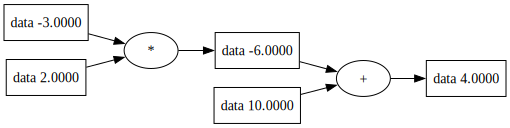

In [12]:
from graphviz import Digraph

def trace(root):
    # recursively builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes: 
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
    
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ data %.4f }" % (n.data), shape='record')
        
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            
            # and connect this node to it
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        # connect n_i to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

# NB: The op nodes are not real objects (rectangles)
# they're simply to visualise which operation (+ or *) was used to create the actual objects (rectangles are real nodes!)
draw_dot(d)

### 4.4. Add labels to understand what variables are where in the visualised graph

In [13]:
class Value:

    # new var _op (empty string for leafs)
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})" 

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
d

Value(data=4.0)

#### 4.4.1. Update graphviz

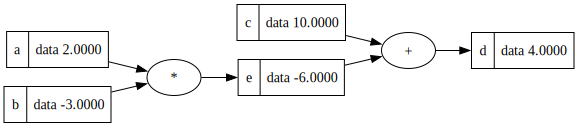

In [14]:
# Redefine graphviz to add this info:
from graphviz import Digraph

def trace(root):
    # recursively builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes: 
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
    
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
        
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            
            # and connect this node to it
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        # connect n_i to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

# NB: The op nodes are not real objects (rectangles)
# they're simply to visualise which operation (+ or *) was used to create the actual objects (rectangles are real nodes!)
draw_dot(d)

#### 4.4.2. Add one more value object (go 1 layer deeper); draw 

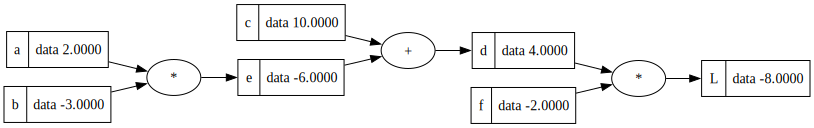

In [15]:
f = Value(-2.0, label='f')
L = d * f; L.label = 'L' # the output of our graph

draw_dot(L)

### 4.5. Finally, update `Value` to maintain the derivative of `L` with respect to each prior node

In [16]:
class Value:

    # new var _op (empty string for leafs)
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # At initialisation, assume every variable has no effect on the output value (L: loss function)
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})" 

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L' # the output of our graph
L

Value(data=-8.0)

### Takeaways:
- That's the forward pass! Its output was `L=-8`
- Next, let's do backpropagation:
    - We'll work **backwards** from `L` node; and calculate the gradient at each of the intermediate values (nodes `a` to `f`)
    - Specifically, compute the derivative of each prior node (`a` to `f`) with respect to the output node `L`


### What's happening?

- In essence, `L` is the "loss function" and the prior nodes `a` to `f` represent the "weights" of a NN
    - Note: "weights" are different to the "data" held at each prior node.
- We're interested in how the weights impact the loss function
    - Hence, the **derivative of the loss function wrt the weights**

#### 4.4.1. Update graphviz

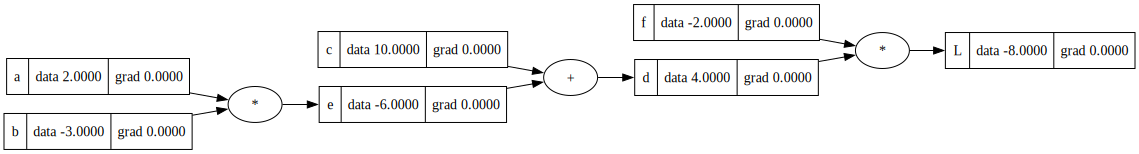

In [17]:
# Redefine graphviz to add this info:
from graphviz import Digraph

def trace(root):
    # recursively builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes: 
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
    
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            
            # and connect this node to it
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        # connect n_i to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

draw_dot(L)

## 5. Backpropagation

### 5.1. Manual backpropagation (fill gradients manually)

#### 5.1.1. Manually fill gradients of `L` wrt nodes `L`, `f`, and `d`

since $L = d \cdot f$, by substituting into the derivative definition we can show for node `f`: 

$$\frac{\mathrm{d}(L)}{\mathrm{d}f} = \frac{f(x+h) - f(x)}{h} = \frac{d \cdot (f+h) - d \cdot f}{h} = \frac{df + dh - df}{h} = \frac{dh}{h} = d$$

Hence, $\frac{\mathrm{d}L}{\mathrm{d}f}=d=4.0$, and by symmetry $\frac{\mathrm{d}L}{\mathrm{d}d}=f=-2.0$

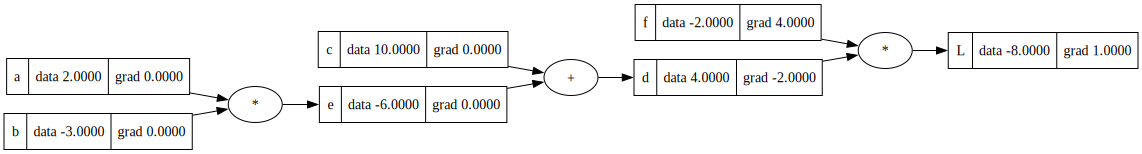

In [18]:
# manually set L.grad (i.e. d(L)/dL = 1) 
L.grad = 1.0 

# since L = d * f, by substituting into the derivative definition: (f(x+h) - f(x))/h, we can show
f.grad = d.data # (bc dL/df = d = 4.0)
d.grad = f.data # (bc dL/dd = f = -2.0)

draw_dot(L) # go and test the new gradients (4.0 and -2.0) via lol()

#### 5.1.2. But what about node `c`? Since it influences `L` **through** node `d`, how do we determine its effect?

First, what is $\frac{\mathrm{d}d}{\mathrm{d}c}$?; Recall: $d=c+e$

$$\frac{\mathrm{d}(d)}{\mathrm{d}c} = \frac{f(x+h) - f(x)}{h} = \frac{((c + h) + e) - (c + e)}{h} = \frac{h}{h} = 1$$

Hence, $\frac{\mathrm{d}d}{\mathrm{d}c}=1.0$, and by symmetry $\frac{\mathrm{d}d}{\mathrm{d}e}=1.0$

---

**Recap:**
* The `+` node knows that `c` and `e` were added to produce `d`
* Also, `+` nodes have local derivative of `1.0` as shown above!
    * Therefore we know the local derivatives `dd/dc` and `dd/de` (both are `1.0`);
    * And from before, we also know how `d` impacts `L`
    * The question: <mark>**How do we know how `L` is impacted by `c`**</mark> (and `e`)?
 
The answer:

#### 5.1.3 The chain rule from calculus

If $z$ depends on the $y$, which itself depends on the $x$ (that is, $y$ and $z$ are dependent variables), then $z$ depends on $x$ as well, via the intermediate variable $y$. 

In this case, the chain rule is expressed as:

$$\frac{\mathrm{d}z}{\mathrm{d}x} = \frac{\mathrm{d}z}{\mathrm{d}y} \cdot \frac{\mathrm{d}y}{\mathrm{d}x} $$

and
$$\left.\frac{\mathrm{d}z}{\mathrm{d}x}\right\rvert_{x} = \left.\frac{\mathrm{d}z}{\mathrm{d}y}\right\rvert_{y(x)} \cdot \left.\frac{\mathrm{d}y}{\mathrm{d}x}\right\rvert_{x} $$

for indicating at which points the derivatives have to be evaluated.

#### Intuitive explanation

Intuitively, the chain rule states that knowing the instantaneous rate of change of z relative to y and that of y relative to x allows one to calculate the instantaneous rate of change of z relative to x as the product of the two rates of change.

As put by George F. Simmons: "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."

#### <mark>Hence we know: `dL/dc = (dL/dd) * (dd/dc)` by the chain rule<mark>

* We know `+` nodes have local derivatives of `1.0` (for all its inputs), so it <mark>**routes the gradient**</mark>!
* Hence, $\frac{\mathrm{d}L}{\mathrm{d}c}=\frac{\mathrm{d}L}{\mathrm{d}d}\cdot\frac{\mathrm{d}d}{\mathrm{d}c}=\frac{\mathrm{d}L}{\mathrm{d}d}\cdot 1.0=\frac{\mathrm{d}L}{\mathrm{d}d}$,
* and by symmetry $\frac{\mathrm{d}L}{\mathrm{d}e}=\frac{\mathrm{d}L}{\mathrm{d}d}$ as well

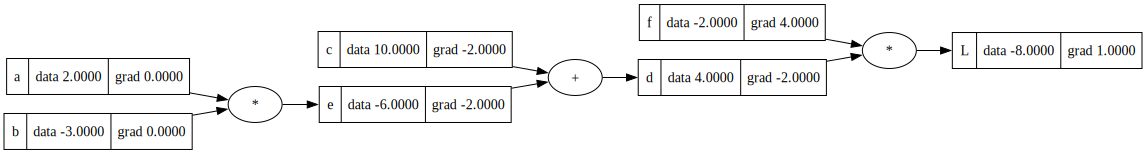

In [19]:
# + nodes simply ROUTE gradients, because their local gradients are 1. 
# So by chain rule, it's simply multiplying by 1
c.grad = d.grad # (dL/dc = (dL/dd) * (dd/dc)) <---- and dd/dc = 1
e.grad = d.grad # (dL/de = (dL/dd) * (dd/de)) <---- and dd/de = 1

draw_dot(L) # go and test the new gradients (-2.0, and -2.0) via lol()

#### Let's apply it again (this time on a `*` (multiplication) node)

We know $\frac{\mathrm{d}L}{\mathrm{d}e}=\frac{\mathrm{d}L}{\mathrm{d}d}=-2$. We want to find $\frac{\mathrm{d}L}{\mathrm{d}a}$ and $\frac{\mathrm{d}L}{\mathrm{d}b}$

Per the chain rule:
$$\frac{\mathrm{d}L}{\mathrm{d}a}=\frac{\mathrm{d}L}{\mathrm{d}e}\cdot\frac{\mathrm{d}e}{\mathrm{d}a}=-2\cdot\frac{\mathrm{d}e}{\mathrm{d}a}$$

As we did earlier for Node `L` (another `*` node), we can say $\frac{\mathrm{d}e}{\mathrm{d}a}=b$ and $\frac{\mathrm{d}e}{\mathrm{d}b}=a$

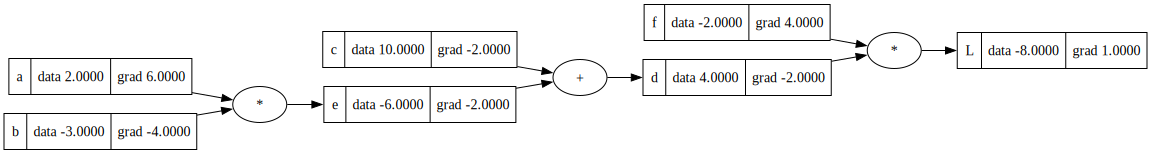

In [20]:
a.grad = e.grad * b.data # (i.e. dL/da = dL/de * de/da = -2 * b = -2 * -3)
b.grad = e.grad * a.data # (i.e. dL/db = dL/de * de/db = -2 * a = -2 * 2)

draw_dot(L) # go and test the new gradients (6.0, and -4.0) via lol()

#### Using this information to <mark>improve the loss function (Node `L`)</mark>

Simply nudge the **leaf nodes'** (`a`, `b`, `c`, `f`) data in the direction of their **own gradients**, then **re-evaluate the nodes who are dependent** on these leaf nodes (`e`, `d`, and `L`).
* i.e. nudge positive gradient nodes in the positive direction and vice versa
* Why only leaf nodes? Because we usually have control over these during the optimisation process.

In [21]:
# nudge each leaf node data in the direction of its gradient
nudge = 0.01

a.data += nudge * a.grad # note how we're nudging each input in the direction of its own gradient
b.data += nudge * b.grad
c.data += nudge * c.grad
f.data += nudge * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)
# re-evaluate the nodes who are dependent on these leaf nodes

-7.286496


In [22]:
def lol():
    '''gating function (like a staging area) for testing our manual calculations above, 
    keeps all vars local to lol(), so avoids polluting global scope
    lets us set small values for 'h' to test dL/d... one variable at a time
    '''

    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a') # add a small amt 'h'
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data # try instead to add 'h' here (instead of to 'a'); convince yourself that d(L)/dL gives you 1

    # therefore display d(L)/da
    print('derivative of L wrt a: \nd(L)/da =', (L2 - L1)/h)

lol()

derivative of L wrt a: 
d(L)/da = 6.000000000021544


### 5.2. Manual backpropagation (train a neuron)

<div>
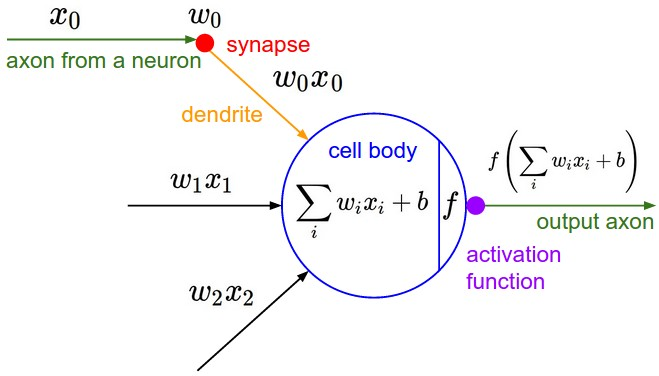
</div>

The activation function, in our example, is the hyperbolic tan function, $\tanh$:

$$\tanh x = \frac{\sinh x}{\cosh x} = \frac{e^x - e^{-x}}{e^x + e^{-x}} = \frac{e^{2x} - 1}{e^{2x} + 1}$$

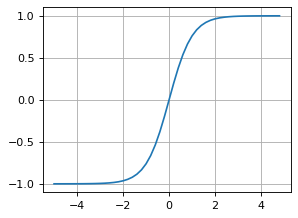

In [23]:
# example activation function: tanh smoothly caps large (+ or -) inputs to +1 or -1 respectively
plt.figure(figsize=(4, 3), dpi=80)
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

#### 5.2.1. First define the forward pass

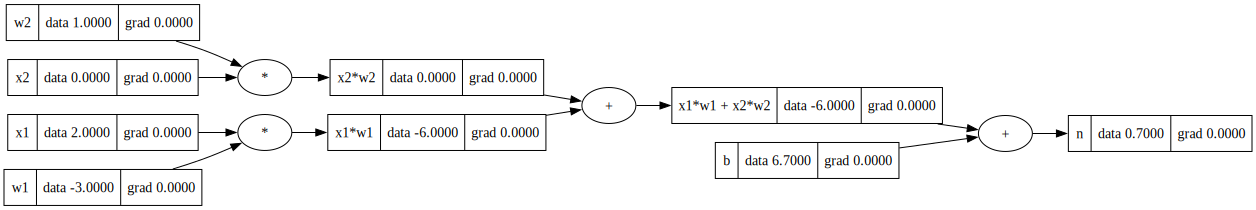

In [24]:
# neuron inputs x1,x2 (2 dimensional neuron)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of neuron w1,w2 (synaptic strengths for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.7, label='b')

# following the graph above to create: x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# cell body raw activation (without the activation function)
n = x1w1x2w2 + b; n.label = 'n'

draw_dot(n)

In [25]:
# output axon (via activation function tanh)
o = n.tanh() # throws error since Python doesn't know how to do tanh for a Value object

AttributeError: 'Value' object has no attribute 'tanh'

##### 5.2.1.1. Defining $\tanh$ in `Value`

* We could implement the ideas of `__div__()` and `exp()` as new methods into our `Value` object, and then reproduce the $\tanh$ operator
* However we can also directly define $\tanh$ as the `tanh` method, as long as we know how to take its local derivative
    * Any arbitrarily complicated function can be directly defined in `Value`, if we know how to take its local derivative

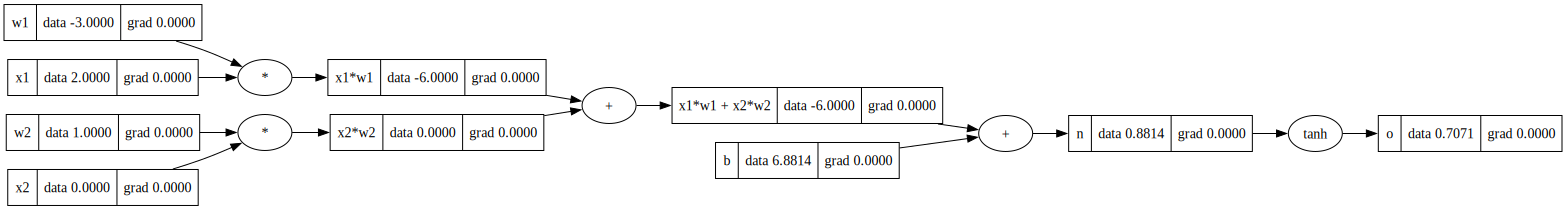

In [31]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})" 

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

    # defining the tanh method (our activation function) in one go!
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh') # the tanh node only has 1 child, so it's a tuple of 1 node "(self, )", and op name is 'tanh'
        return out

# redefine inputs (x1,x2), weights (w1,w2), and then the graph (n = x1*w1 + x2*w2 + b)
x1 = Value(2.0, label='x1'); x2 = Value(0.0, label='x2'); w1 = Value(-3.0, label='w1'); w2 = Value(1.0, label='w2')
x1w1 = x1 * w1; x1w1.label = 'x1*w1'; x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# manually change bias to make number nice for education: (b=8 to see tanh squishing!, b=6.8813735870195432 so deriv = 1)
b = Value(6.8813735870195432, label='b')
n = x1w1x2w2 + b; n.label = 'n'

# try re-run the activation function on n (the raw cell body) and draw the output node o
o = n.tanh(); o.label = 'o'
draw_dot(o)

#### 5.2.2. Now the backward pass (backpropagation)

* We're particularly interested in $\frac{\mathrm{d}o}{\mathrm{d}w_1}$ and $\frac{\mathrm{d}o}{\mathrm{d}w_2}$
    * This is because the weights, $w_1$ and $w_2$, are what we're able to change as we "train" a neural net.
* Also note, this is only 1 neuron. A real NN has many connected neurons
    * The loss function is at the very end of that NN, and measures the NN's accuracy (a goalpost for the NN's backpropagation)

In [45]:
# manually set o.grad (i.e. d(o)/do = 1) 
o.grad = 1.0

# we know o = tanh(n); 
# per wikipedia (or calculus): d()/dx tanh(x) = 1 - ( tanh(x))^2;
# therefore: do/dn = 1 - tanh(n)**2 (and we know tanh(n) is o.data!)
n.grad = 1 - o.data**2

n.grad # (0.5 in this ex.)

# n's incoming nodes enter via a '+' node, so n's gradient is simply routed back (i.e. 0.5 again):
x1w1x2w2.grad = n.grad
b.grad = n.grad 

# same logic for x1w1x2w2's incoming nodes (another '+' node); route x1w1x2w2 gradient!
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad 

# the final 4 nodes (x1, w1, x2, w2) flow thru a '*' node. Per the (local) CHAIN RULE, their local gradients are:
x1.grad = x1w1.grad * w1.data # do/dx1 = do/dx1w1 * d(x1w1)/dx1 = x1w1.grad * w1.data = 0.5 * -3 = -1.5
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

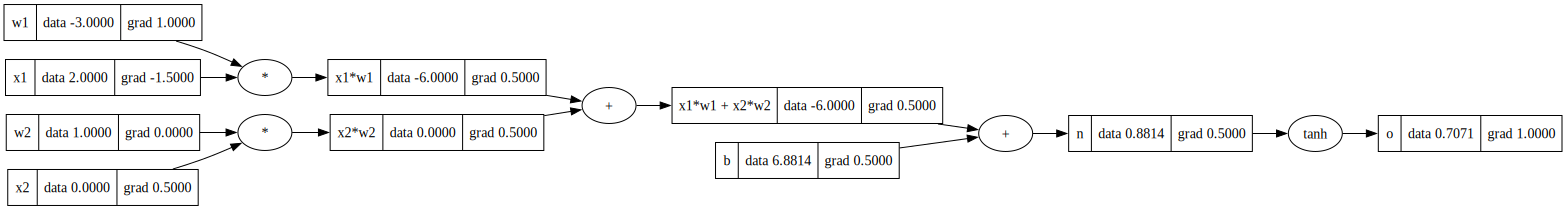

In [44]:
draw_dot(o)

##### 5.2.2.1 Analysis of this backpropagation graph

* Note how `w2.grad = 0` in the graph above.
* This makes sense because `w2.grad` tells us how nudging `w2` affects the final output `o`
    * Since `x2` (the neuron input) is `0`; it doesn't matter how we nudge `w2`. `o` remains unchanged (because `x2*w2` go through a `*` node)
    * So `o` is totally insensitive to `w2`, hence `w2.grad = 0`

## Final `Value` object

In [ ]:
# class Value:
#     """docstring from GH Copilot
#     A class that represents a single value and its gradient.

#     This class is used to perform automatic differentiation. It keeps track of a value (`data`), its gradient (`grad`), 
#     and the function (`_backward`) used to compute the gradient. The class also supports basic arithmetic operations 
#     like addition (`__add__`) and multiplication (`__mul__`), as well as the hyperbolic tangent function (`tanh`).
                    
#     Attributes:
#         data:       The actual value.
#         grad:       The gradient of the value.
#         _backward:  A function that computes the gradient.
#         _prev:      A set of `Value` objects that are the parents of this object in the computation graph.
#         _op:        A string representing the operation that produced this `Value` object.
#         label:      An optional label for the `Value` object.

#     Methods:
#         tanh:       Applies the hyperbolic tangent function to the value.
#         backward:   Performs backpropagation to compute the gradients of all values in the computation graph.
#     """

#     # NB: __init__ is auto-called when you create a new instance of a class. they initialise the attributes of the class.
#     def __init__(self, data, _children=(), _op='', label=''):
#         self.data = data
#         self.grad = 0.0
#         self._backward = lambda: None
#         self._prev = set(_children)
#         self._op = _op
#         self.label = label

#     # NB: __repr__ is a Py built-in function: provides a string representation of an obj. for debugging, logging, etc
#     def __repr__(self):
#         return f"Value(data={self.data})" 
  
#     def __add__(self, other):
#         out = Value(self.data + other.data, (self, other), '+')
        
#         def _backward():
#             self.grad += 1.0 * out.grad
#             other.grad += 1.0 * out.grad
#         out._backward = _backward
        
#         return out

#     def __mul__(self, other):
#         out = Value(self.data * other.data, (self, other), '*')
        
#         def _backward():
#             self.grad += other.data * out.grad
#             other.grad += self.data * out.grad
#         out._backward = _backward
        
#         return out
  
#     def tanh(self):
#         x = self.data
#         t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
#         out = Value(t, (self, ), 'tanh')
    
#         def _backward():
#             self.grad += (1 - t**2) * out.grad
#         out._backward = _backward
    
#         return out
  
#     def backward(self):
    
#         topo = []
#         visited = set()
#         def build_topo(v):
#             if v not in visited:
#                 visited.add(v)
#                 for child in v._prev:
#                     build_topo(child)
#                 topo.append(v)
#         build_topo(self)
        
#         self.grad = 1.0
#         for node in reversed(topo):
#             node._backward()

# a = Value(2.0, label='a')
# b = Value(-3.0, label='b')
# c = Value(10.0, label='c')
# e = a*b; e.label = 'e'
# d = e + c; d.label = 'd'
# f = Value(-2.0, label='f')
# L = d * f; L.label = 'L'
# L